Exploring Socioeconmic Features
===============================

This notebook explores various socioeconomic features in the Titanic dataset, such as Pclass, Title and Fare. Preliminary investigation of the dataset indicate thart these three features have a strong impact on survivability.

In [88]:
# set up code and dataframe with training data
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.metrics as ms
import sklearn.model_selection as mds
import sklearn.tree as tr

datestamp = "20250227.103109"
df_ = pd.read_csv(f"../data/kaggle/train.clean.{datestamp}.csv")
print(df_.shape)

(891, 56)


# Examining the "Mr" Title

## By Survival Rate

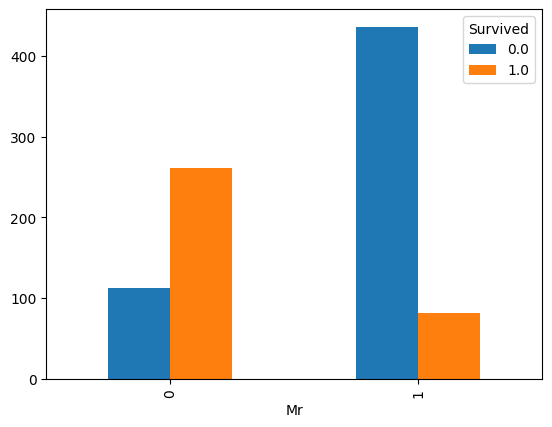

In [89]:
# set up the X, y values for the train and test sets
x_colname = 'Mr'
y_colname = 'Survived'

# transform the dataframe, so that it can be properly graphed as a bar plot
df_group_count = df_.groupby([x_colname, y_colname])[x_colname].count()
df_misters_grouped = df_group_count.unstack(y_colname)
df_misters_grouped.plot(kind='bar')
plt.show()

## General Survival Rate by Pclass

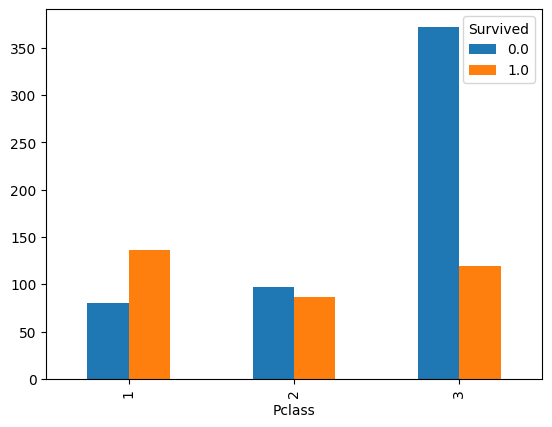

In [90]:
# set up the X, y values for the train and test sets
x_colname = 'Pclass'
y_colname = 'Survived'

# transform the dataframe, so that it can be properly graphed as a bar plot
df_group_count = df_.groupby([x_colname, y_colname])[x_colname].count()
df_pclass_grouped = df_group_count.unstack(y_colname)
df_pclass_grouped.plot(kind='bar')
plt.show()

## Explore Mr Title By Pclass Ranking

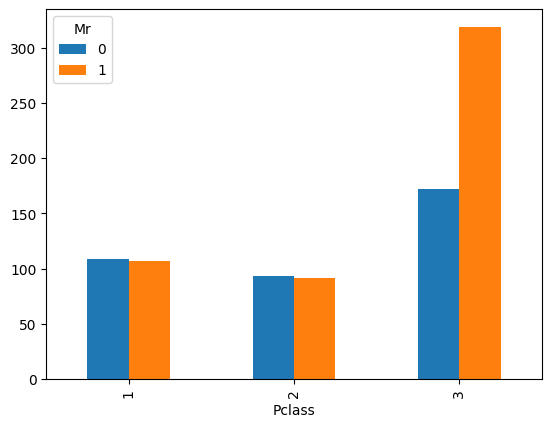

In [91]:
# set up the X, y values for the train and test sets
x_colname = 'Pclass'
y_colname = 'Mr'

# transform the dataframe, so that it can be properly graphed as a bar plot
df_group_count = df_.groupby([x_colname, y_colname])[x_colname].count()
df_pclass_grouped = df_group_count.unstack(y_colname)
df_pclass_grouped.plot(kind='bar')
plt.show()

## Include Other Titles with Low Survival

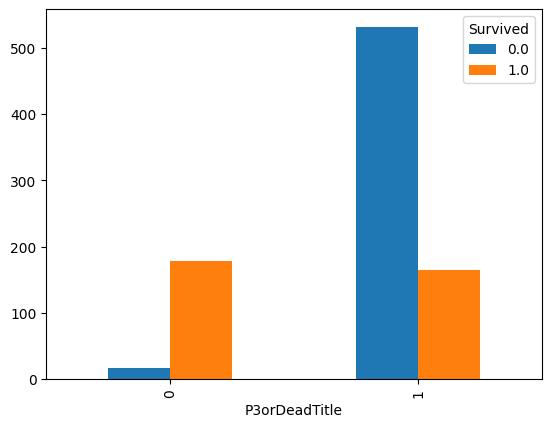

In [92]:
#df_["NonP3NonMisters"] = df_.apply( lambda k: 1 if ((k.Mr == 0) and (k.Pclass < 3)) else 0, axis=1 )

# set up the X, y values for the train and test sets
x_colname = 'P3orDeadTitle'
y_colname = 'Survived'

# transform the dataframe, so that it can be properly graphed as a bar plot
df_group_count = df_.groupby([x_colname, y_colname])[x_colname].count()
df_pclass_grouped = df_group_count.unstack(y_colname)
df_pclass_grouped.plot(kind='bar')
plt.show()

# Graph Fare Per Person

Given the discrepancy between PClass 1 / 2, and PClass 3, it's worth exploring how FarePerPerson maps to the PClass values, especially across PClass 1 and PClass 2. To reduce the impact of outliers, the FarePerPerson feature is run through two different normalization functions: Robust and MinMax.

## Fare Per Person in PClass 3

(479, 56)


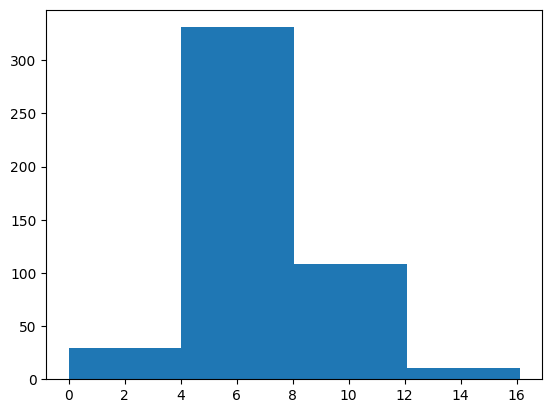

In [93]:
df_pclass3_sub = df_[ (df_[ "Pclass" ] == 3) & (df_[ "FppRobust" ] < 0.5 ) ]
print(df_pclass3_sub.shape)

p3_num_bins = 4

plt.hist(df_pclass3_sub[[ "FarePerPerson" ]], bins=p3_num_bins)
plt.show()

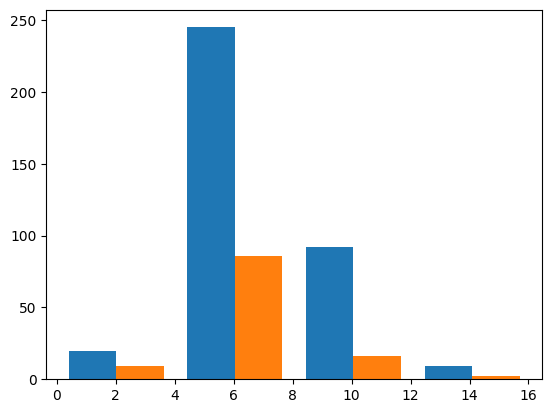

In [94]:
df_surv = df_pclass3_sub[ df_pclass3_sub[ y_colname ] == 0 ].pivot(columns=y_colname, values='FarePerPerson')
df_nsrv = df_pclass3_sub[ df_pclass3_sub[ y_colname ] == 1 ].pivot(columns=y_colname, values='FarePerPerson')

counts, bins, patches = plt.hist([df_surv[0], df_nsrv[1]], bins=p3_num_bins)
plt.show()

Who were the people who were in 3rd class, but payed more than $15 per person?

In [95]:
df_fpp_sub = df_[ (df_[ "Pclass" ] == 3) & (df_[ "FarePerPerson" ] > 15 ) ].sort_values(by="FarePerPerson", ascending=False)
df_fpp_sub[[ "Name", "Survived", "Age", "Sex", "FarePerPerson", "FppRobust", "GroupSize", "Fare", "Cabin", "Embarked" ]]

,Name,Survived,Age,Sex,FarePerPerson,FppRobust,GroupSize,Fare,Cabin,Embarked
74,"Bing, Mr. Lee",1.0,32.0,male,56.4958,2.8770,1,56.4958,NaN,S
169,"Ling, Mr. Lee",0.0,28.0,male,56.4958,2.8770,1,56.4958,NaN,S
509,"Lang, Mr. Fang",1.0,26.0,male,56.4958,2.8770,1,56.4958,NaN,S
643,"Foo, Mr. Choong",1.0,NaN,male,56.4958,2.8770,1,56.4958,NaN,S
692,"Lam, Mr. Ali",1.0,NaN,male,56.4958,2.8770,1,56.4958,NaN,S
826,"Lam, Mr. Len",0.0,NaN,male,56.4958,2.8770,1,56.4958,NaN,S
838,"Chip, Mr. Chang",1.0,32.0,male,56.4958,2.8770,1,56.4958,NaN,S
517,"Ryan, Mr. Patrick",0.0,NaN,male,24.1500,0.9398,1,24.1500,NaN,Q
811,"Lester, Mr. James",0.0,39.0,male,24.1500,0.9398,1,24.1500,NaN,S
508,"Olsen, Mr. Henry Margido",0.0,28.0,male,22.5250,0.8425,1,22.5250,NaN,S


## Fare Per Person in Pclass 1 and 2

(298, 56)


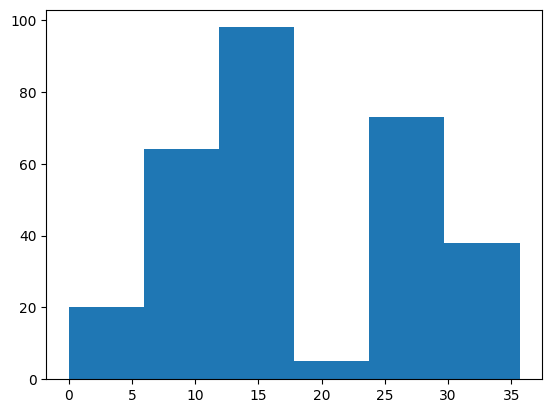

In [107]:
df_pclass_sub = df_[ (df_[ "Pclass" ] < 3) & (df_[ "FarePerPerson" ] < 36 ) ]
print(df_pclass_sub.shape)

num_bins=6

plt.hist(df_pclass_sub[[ "FarePerPerson" ]], bins=num_bins)
plt.show()

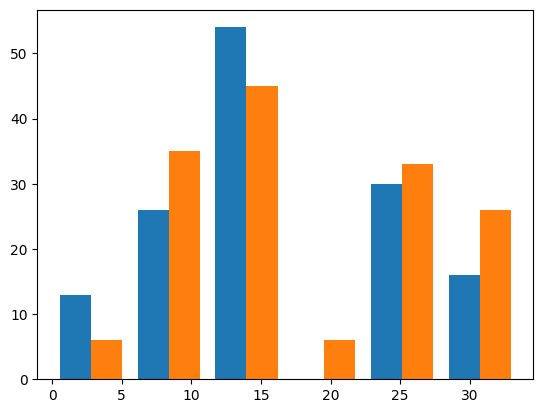

In [97]:
df_surv = df_pclass_sub[ df_pclass_sub[ y_colname ] == 0 ].pivot(columns=y_colname, values='FarePerPerson')
df_nsrv = df_pclass_sub[ df_pclass_sub[ y_colname ] == 1 ].pivot(columns=y_colname, values='FarePerPerson')

counts, bins, patches = plt.hist([df_surv[0], df_nsrv[1]], bins=num_bins)
plt.show()

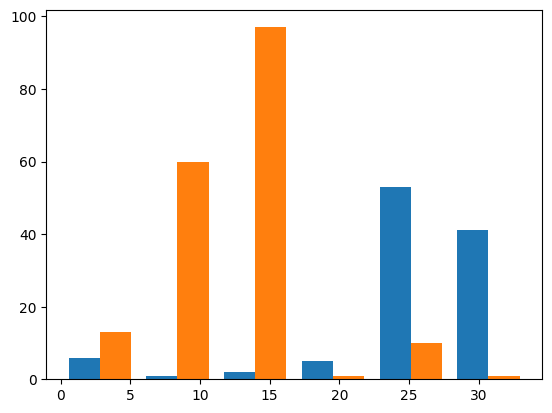

In [98]:
df_p1 = df_pclass_sub[ df_pclass_sub[ "Pclass" ] == 1 ].pivot(columns="Pclass", values='FarePerPerson')
df_p2 = df_pclass_sub[ df_pclass_sub[ "Pclass" ] == 2 ].pivot(columns="Pclass", values='FarePerPerson')

counts, bins, patches = plt.hist([df_p1[1], df_p2[2]], bins=num_bins)
plt.show()

# Create a Binary Tree

The graph above shows us that we can see a STRONG correlation by folks that survived, and the folks that didn't have the title "Mr" (not poor) and were rated Pclass 1 or Pclass 2. To do another round of analysis, let's use a new feature from the dataset that marks anyone with PClass 3 or a "non-survivng title" (Dr, Mr, Capt). Building this into our binary tree classifier should give us further insights into the nature of the data.

In [99]:
x_colnames = [ 'Pclass', 'P3orDeadTitle', 'FarePerPerson', 'AgeImputed' ]

X = df_[ x_colnames]
y = df_[ 'Survived' ].values

# Assuming you have your features in X and your target variable in y
X_train, X_test, y_train, y_test = mds.train_test_split(X, y, test_size=0.5)

n_folds = 6
s_scoring = "balanced_accuracy"

param_dist = {
    'max_leaf_nodes': [ 8  ],
    'max_depth': [ 6 ],
    'min_samples_split': [ 25 ],
    'min_samples_leaf': [ 10 ]
} 

# Create a decision tree classifier
clf = tr.DecisionTreeClassifier(criterion='gini')

grid_search = mds.GridSearchCV( estimator=clf,
                                param_grid=param_dist,
                                cv=n_folds,
                                scoring=s_scoring,
                                n_jobs=-1 )

# Train the classifier
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
model       = grid_search.best_estimator_

print(best_params)
print()

{'max_depth': 6, 'max_leaf_nodes': 8, 'min_samples_leaf': 10, 'min_samples_split': 25}



In [100]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame(
    {'Feature': x_colnames, 'Gini Importance': importances} ).sort_values(
         'Gini Importance', ascending=False)
print(feature_imp_df)

         Feature  Gini Importance
1  P3orDeadTitle         0.734381
2  FarePerPerson         0.207815
3     AgeImputed         0.057804
0         Pclass         0.000000


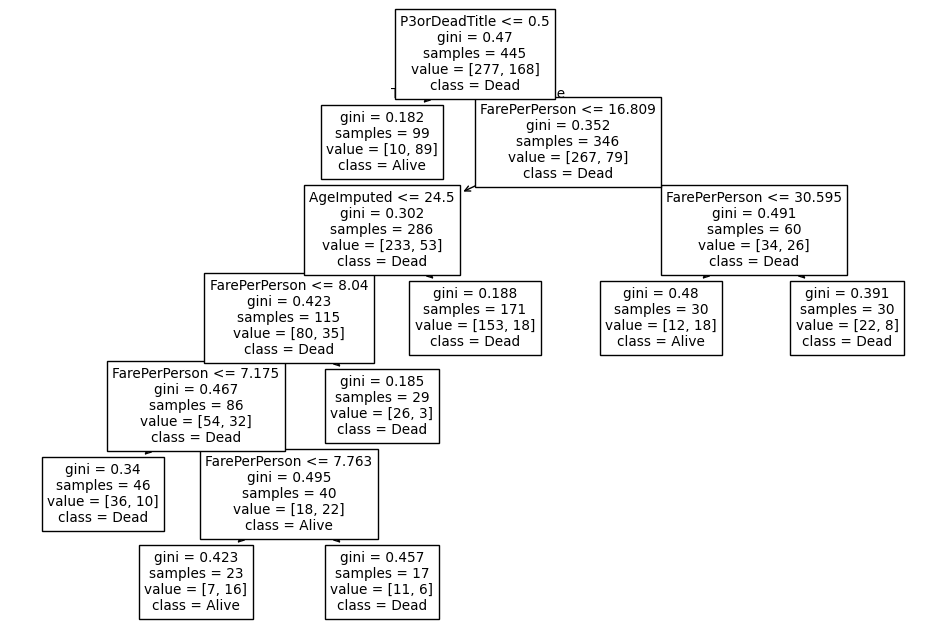

In [101]:
plt.figure(figsize=(12, 8))
tr.plot_tree(model, feature_names=x_colnames, class_names=['Dead', 'Alive'])
plt.show()

In [102]:
threshold_tuner = mds.TunedThresholdClassifierCV(
    clf, scoring='f1_micro').fit(X_test, y_test)
threshold = threshold_tuner.best_threshold_

print(f"Threshold {round(threshold,3)} gives score: {round(threshold_tuner.best_score_,2)}")
print()


Threshold 0.404 gives score: 0.73



# Analyze the Tree

How does the Decision Tree classifier perform? We know from previous experiments, that the Titanic test set seems to favor precision over recall, so the model will lean put a higher value on identifying positive survivors.

In [105]:
threshold = 0.7

y_test_preds_proba = model.predict_proba(X_test)
y_test_preds = (y_test_preds_proba[:,1] > threshold).astype(int)

tn, fp, fn, tp = ms.confusion_matrix(y_test, y_test_preds).ravel()
print(f"Confusion Matrix, at Threshold {threshold:.3f}")
print(f"  tn {tn:<3}  fp {fp:<3}")
print(f"  fn {fn:<3}  tp {tp:<3}")
print()

bal_acc   = round( ms.balanced_accuracy_score( y_test, y_test_preds ), 3 )
precision = round( ms.precision_score( y_test, y_test_preds ), 3 )
recall    = round( ms.recall_score( y_test, y_test_preds ), 3 )
f1        = round( ms.f1_score( y_test, y_test_preds, average='micro' ), 3 )

s_scores = f"Bal Acc: {bal_acc}, Pre: {precision}, Rec: {recall}, F1 Micro: {f1}"
print(s_scores)

Confusion Matrix, at Threshold 0.700
  tn 265  fp 7  
  fn 85   tp 89 

Bal Acc: 0.743, Pre: 0.927, Rec: 0.511, F1 Micro: 0.794


In [106]:
df_test = pd.read_csv(f"../data/kaggle/test.clean.{datestamp}.csv")

y_proba = model.predict_proba(df_test[x_colnames])
y_preds = (y_proba[:,1] > threshold).astype(int)

df_test["SurvivedProbability"] = y_proba[:,1]
df_test["Survived"] = y_preds

#df_sub[["Pclass", "Name", "Sex", "GroupSize", "AgeImputed", "AgeRobust", "FppRobust", "SurvivedProbability", "Survived"]].head(15)
df_test[["PassengerId", "Survived"]].to_csv(f"../data/kaggle/submit.socioeconomic.csv", index=False)